# UCI Heart Disease Project Report for Predicting Heart Disease
#### By: William Chow

## Introduction

Heart diseases are deadly because it can affect the heart and blood vessels which, in turn, could cause heart attacks or strokes. This is why detecting signs of heart disease early is important so it can be treated. Angiography, which is a type of X-ray used to check blood vessels is useful in detecting heart diseases. So, could age, chest pain (cp), cholesterol (chol), resting blood pressure (thalbps), and exercise induced angina (exang) predict the presence of heart disease?

The heart disease we are trying to predict is CAD which stands for Coronary artery disease, this disease occurs when coronary arteries narrow or become blocked, and as a result fail to supply blood, oxygen, and nutrients to the heart.

This is the dataset that will be used: [UCI Heart Disease](https://archive.ics.uci.edu/dataset/45/heart+disease)

We will be using the Hungarian dataset to predict heart disease. The data set also contains 14 attributes and will be used to predict the presence of heart disease in patients.

## Methods & Results

We will use `age`, `sex`, chest pain type (`cp`), resting blood pressure (`trestbps`), cholesterol (`chol`), and exercise induced angina (`exang`) as predictors to predict the presence of heart disease (`num`). If heart disease is present then it will symbolize a $1$, if heart disease is not present then it will symbolize as a $0$.

The model we will be using is the K-Nearest Neighbors model for classification prediction.

We will use a confusion matrix to display the results to see how well the accuracy, precision, and recall perform on the trained model.

Before starting any code, we will first load the necessary libraries needed for the project.

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(cowplot)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

First we need to download the Hungarian Heart Disease dataset from my public github repository as a raw github `.data` file into the current working directory.

In [2]:
hungarian_data_url <- "https://raw.githubusercontent.com/wchow03/dsci-100-2024s1/main/data/heart_disease/processed.hungarian.data"
download.file(hungarian_data_url, "hungarian_data.data")

In [3]:
disease_cols <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "slope", "oldpeak", "ca", "thal", "num")
hungarian_data <- read_csv("hungarian_data.data", col_names=disease_cols)

head(hungarian_data)

Rows: 294 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): trestbps, chol, fbs, restecg, thalach, exang, oldpeak, ca, thal
dbl (5): age, sex, cp, slope, num

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,slope,oldpeak,ca,thal,num
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>
28,1,2,130,132,0,2,185,0,0,?,?,?,0
29,1,2,120,243,0,0,160,0,0,?,?,?,0
29,1,2,140,?,0,0,170,0,0,?,?,?,0
30,0,1,170,237,0,1,170,0,0,?,?,6,0
31,0,2,100,219,0,1,150,0,0,?,?,?,0
32,0,2,105,198,0,0,165,0,0,?,?,?,0


Since all the data types in the dataset are doubles according the the website, we will need to convert all the columns to double as some of them are characters, except for `num` as that will be the target column so it will be of type `factor`. We will also need to replace all "?" with NA so it will not error when running R code.

In [4]:
# Convert all columns to chr first, then use na_if to replace all "?" with NA, after replacing all "?" convert all columns back to numeric as per data set specs from website.
# Reference here: https://dplyr.tidyverse.org/reference/na_if.html
hungarian_tidydata <- hungarian_data |>
                    mutate(across(everything(), ~ na_if(as.character(.), "?"))) |>
                    mutate(across(everything(), as.numeric))
head(hungarian_tidydata)

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,slope,oldpeak,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
28,1,2,130,132,0,2,185,0,0,NA,NA,NA,0
29,1,2,120,243,0,0,160,0,0,NA,NA,NA,0
29,1,2,140,NA,0,0,170,0,0,NA,NA,NA,0
30,0,1,170,237,0,1,170,0,0,NA,NA,6,0
31,0,2,100,219,0,1,150,0,0,NA,NA,NA,0
32,0,2,105,198,0,0,165,0,0,NA,NA,NA,0


Next we will split the dataset into train and test splits so we can test the accuracy of our model and see how well it generalizes to unseen data at the end.

We will be splitting the data into 70% as the training set and 30% as the testing set.

Before splitting the dataset we will also filter the dataset to only contain the columns that contain our predictor variables as well as the target variable. These variables are: `age`, `sex`, `cp`, `trestbps`, `chol`, `exang`, and `num`. We will also drop any rows that contain NA thus to not interfere when created the KNN model.

In [5]:
set.seed(420) # Set seed for reproducibility

hungarian_filtered <- hungarian_tidydata |>
                        select(age:chol, exang, num) |>
                        mutate(num = as_factor(num)) |>
                        drop_na()
hungarian_split <- initial_split(hungarian_filtered, prop=0.7, strata=num)
hungarian_train <- training(hungarian_split)
hungarian_test <- testing(hungarian_split)

Below is a dataframe summarizing the means of each predictor variable that is in the training set.

In [6]:
hungarian_train |>
    select(-num) |>
    map_df(mean, na.rm=TRUE)

age,sex,cp,trestbps,chol,exang
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
48.03723,0.7393617,3,133.5638,252.7447,0.3244681


Next we will create a histograms and bar plots to examine the distribution of the predictor variables.

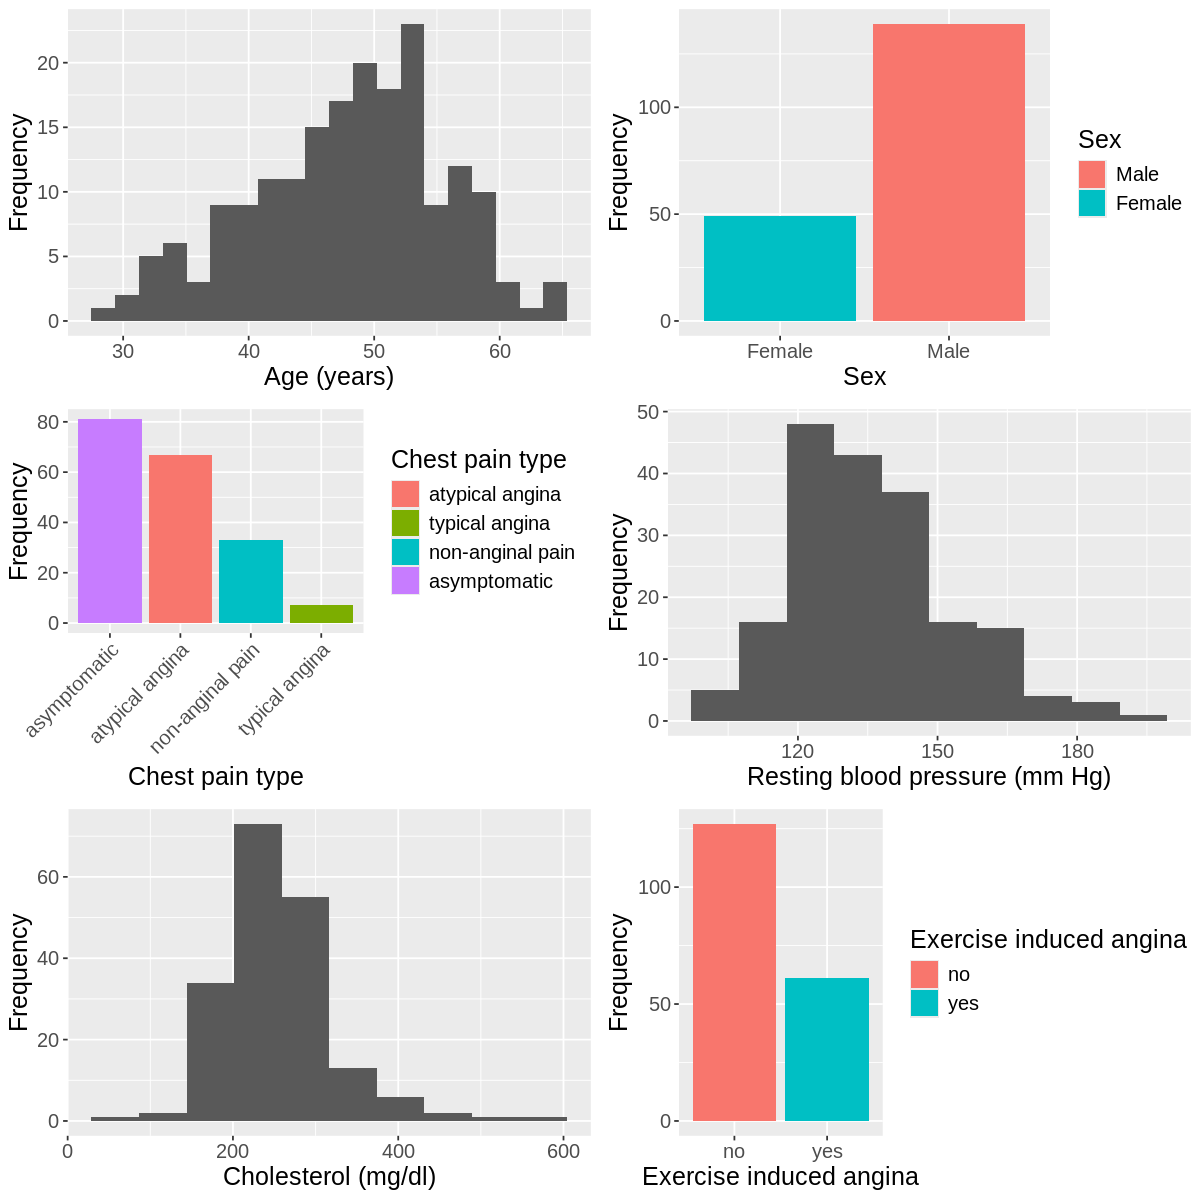

In [7]:
options(repr.plot.width=10, repr.plot.height=10)
age_plot <- ggplot(hungarian_train, aes(x=age)) +
                geom_histogram(bins=20) +
                labs(x="Age (years)", y="Frequency") +
                theme(text=element_text(size=15))
# Code for mutate referenced here: https://stackoverflow.com/questions/48571773/how-do-i-replace-multiple-character-strings-in-a-column-to-numbers
sex_column <- hungarian_train |>
                select(sex) |>
                mutate(sex_str=case_when(sex==0 ~ "Female", sex==1 ~ "Male"))

sex_plot <- ggplot(sex_column, aes(x=sex_str, fill=as_factor(sex_str))) +
                geom_bar() +
                labs(x="Sex", y="Frequency", fill="Sex") +
                theme(text=element_text(size=15))

cp_column <- hungarian_train |>
                select(cp) |>
                mutate(cp_str=case_when(cp==1 ~ "typical angina", cp==2 ~ "atypical angina", cp==3 ~ "non-anginal pain", cp==4 ~ "asymptomatic"))

cp_plot <- ggplot(cp_column, aes(x=cp_str, fill=as_factor(cp_str))) +
            geom_bar() +
            labs(x="Chest pain type", y="Frequency", fill="Chest pain type") +
            theme(text=element_text(size=15), axis.text.x = element_text(angle=45, hjust=1))

trestbps_plot <- ggplot(hungarian_train, aes(x=trestbps)) +
                geom_histogram(bins=10) +
                labs(x="Resting blood pressure (mm Hg)", y="Frequency") +
                theme(text=element_text(size=15))

chol_plot <- ggplot(hungarian_train, aes(x=chol)) +
                geom_histogram(bins=10) +
                labs(x="Cholesterol (mg/dl)", y="Frequency") +
                theme(text=element_text(size=15))

exang_column <- hungarian_train |>
                select(exang) |>
                mutate(exang_str=case_when(exang==0 ~ "no", exang==1 ~ "yes")) |>
                filter(exang != "NA")

exang_plot <- ggplot(exang_column, aes(x=exang_str, fill=as_factor(exang_str))) +
            geom_bar() +
            labs(x="Exercise induced angina", y="Frequency", fill="Exercise induced angina") +
            theme(text=element_text(size=15))

plot_grid(age_plot, sex_plot, cp_plot, trestbps_plot, chol_plot, exang_plot, nrow=3, ncol=2)

<br>

The next step is to create the KNN model and fit it on our dataset.

First we will need to scale and center the values, so we will create a recipe

In [8]:
set.seed(420)
hungarian_recipe <- recipe(num ~., data=hungarian_train) |>
                        step_scale(all_predictors()) |>
                        step_center(all_predictors())
hungarian_recipe



── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 6



── Operations 

• Scaling for: all_predictors()

• Centering for: all_predictors()



After creating the recipe we will create the spec for our KNN model.

We will do cross-validation to find the optimal number of neighbors ($n$) for the KNN model.

In [9]:
set.seed(420)
knn_spec_tune <- nearest_neighbor(weight_func="rectangular", neighbors=tune()) |>
                set_engine("kknn") |>
                set_mode("classification")
knn_spec_tune

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


Now, we will create a `workflow()` and run cross-validation to test a list of neighbors from `1` to `20`.

In [10]:
set.seed(420)

# create cv=5
training_vfold <- vfold_cv(hungarian_train, v=5, strata=num)

k_vals <- tibble(neighbors = 1:20)

knn_results <- workflow() |>
                add_recipe(hungarian_recipe) |>
                add_model(knn_spec_tune) |>
                tune_grid(resamples=training_vfold, grid=k_vals) |>
                collect_metrics()

We will then create a plot of accuracy against number of neighbors to visually see which $n$ performs the best.

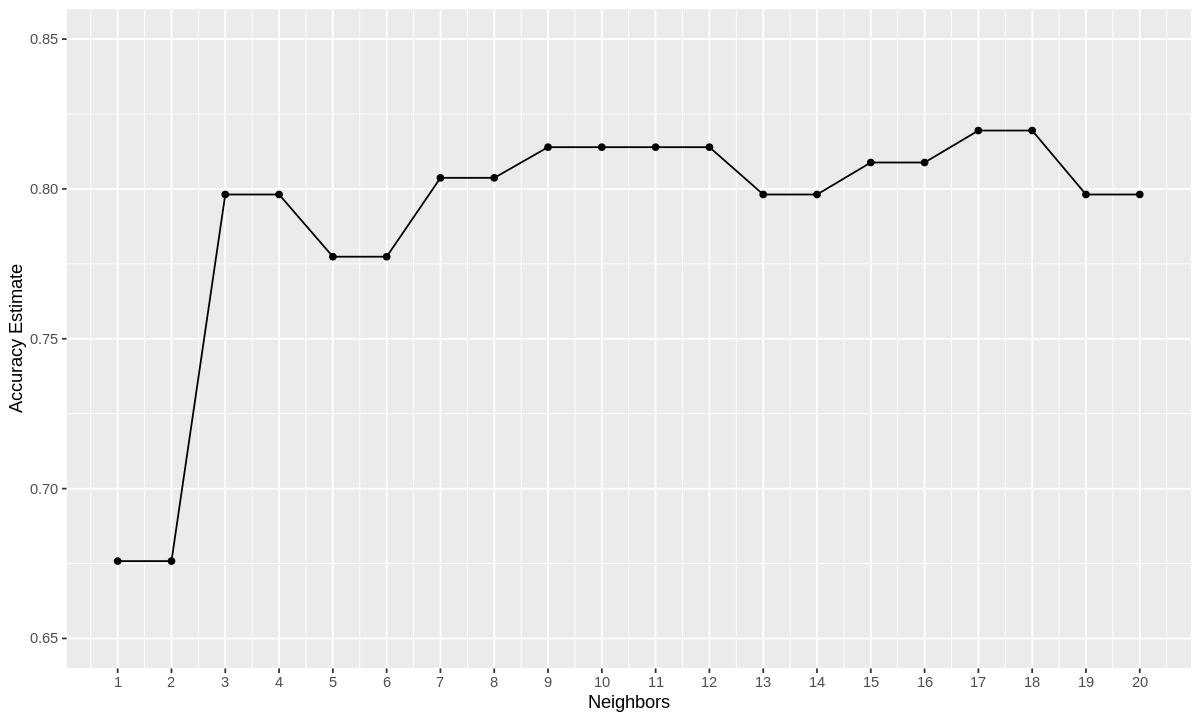

In [11]:
options(repr.plot.width=10, repr.plot.height=6)
accuracies <- knn_results |>
                filter(.metric=="accuracy")
cross_val_plot <- ggplot(accuracies, aes(x=neighbors, y=mean)) +
                    geom_point() +
                    geom_line() +
                    labs(x="Neighbors", y="Accuracy Estimate") +
                    scale_x_continuous(breaks = seq(0, 20, by=1)) +
                    scale_y_continuous(limits = c(0.65, 0.85)) # scale y-axis to closely examine differences in scores of different neighbors
cross_val_plot

From the plot above it seems as though $k=17$ gives the best accuracy, so we will use that in training our final model.

Next, we will create another KNN spec with $k=17$ as the number of neighbors as reuse the recipe defined above. Then we can fit the model on the training set.

In [12]:
set.seed(420)

knn_spec_final <- nearest_neighbor(weight_func="rectangular", neighbors=17) |>
                    set_engine("kknn") |>
                    set_mode("classification")
knn_fit <- workflow() |>
            add_recipe(hungarian_recipe) |>
            add_model(knn_spec_final) |>
            fit(data=hungarian_train)
knn_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(17,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.1968085
Best kernel: rectangular
Best k: 17

Next we will use the final model to predict on the test set and display the confusion matrix.

In [13]:
set.seed(420)

hungarian_predictions <- predict(knn_fit, hungarian_test) |>
                            bind_cols(hungarian_test)
hungarian_conf_mat <- hungarian_predictions |>
                        conf_mat(truth=num, estimate=.pred_class)
hungarian_conf_mat

          Truth
Prediction  0  1
         0 45  9
         1  6 22

From the confusion matrix above, we can calculate the **accuracy**, **precision** as well as **recall**.

First we will use the `levels()` function to see which position $1$ is as that is what we will designate as the "positive" class

In [14]:
hungarian_predictions |> pull(num) |> levels()

[1] "0" "1"

We can see that $1$ is "second".

First, we will calculate the **accuracy** of the model using the `accuracy` function.

In [15]:
hungarian_predictions |>
    accuracy(truth=num, estimate=.pred_class, event_level="second")

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8170732


Next, we will calculate the **precision** of the model using the `precision` function.

In [16]:
hungarian_predictions |>
    precision(truth=num, estimate=.pred_class, event_level="second")

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.7857143


Finally we will calculate the **recall** of the model using the `recall` function.

In [17]:
hungarian_predictions |>
    recall(truth=num, estimate=.pred_class, event_level="second")

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0.7096774


## Discussion

Through training a K-Nearest Neighbor model for predicting if a patient has heart disease or not, we have came to the conclusion of these scores based off of the testing set.

Around 82% accuracy, 79% precision, and 71% recall. These scores are impressive as the model does not make too many mistakes with classifying false-positives as well as false-negatives. The accuracy and precision being close in score and also being relatively high is good as it means it can accurately and precisely predict if the patient has heart disease or not majority of the time. With the recall score being about 71% also means that it correctly predicted heart disease in the test set. 

We expected to find it to be at least above 65% in accuracy but was not expecting to achieve above 80% accuracy after training the model.

The impact this can make is crucial as predicting if patients have heart disease early on can help cure patients and save many lives. The model we have trained contain little false-negatives which is important because if we predicted a patient to not have heart disease but in reality they did, it could cause severe consequences.

With this in mind, there are are a few questions that future research may look into:

Which of the predictor variables are the most significant in predicting heart disease?

Could the presence of heart disease be predicted with fewer variables than I have proposed? If so, then it could mean that we need to collect less data about patients to figure out if heart disease is present or not.

## References

Pal M, Parija S, Panda G, Dhama K, Mohapatra RK. "Risk prediction of cardiovascular disease using machine learning classifiers." Open Med (Wars), 2022, vol. 17, no. 1, pp. 1100-1113. https://doi.org/10.1515%2Fmed-2022-0508

Coronary artery disease (CAD): https://www.mayoclinic.org/diseases-conditions/coronary-artery-disease/symptoms-causes/syc-20350613#:~:text=CAD%20happens%20when%20coronary%20arteries,or%20even%20a%20heart%20attack.

Data source: https://archive.ics.uci.edu/dataset/45/heart+disease